In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.9 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.1 MB 3.0 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.1 MB 3.2 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 3.4 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.6 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 3.8 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 3.7 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.0 MB/s  0:00:02
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------- ---------

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib


# set display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


DATA_PATH = 'D:/fake-website-detector/data/dataset_phishing.csv' # adjust if your working directory differs
MODEL_OUT = 'D:/fake-website-detector/models'


print('Notebook ready')

Notebook ready


In [8]:
# Cell 2 — load data
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (11430, 89)


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


In [9]:
# Cell 3 — info & nulls
df.info()


# Summary of missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0].head(30)


# Show columns list
print(list(df.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

Label unique values: ['legitimate' 'phishing']
status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64


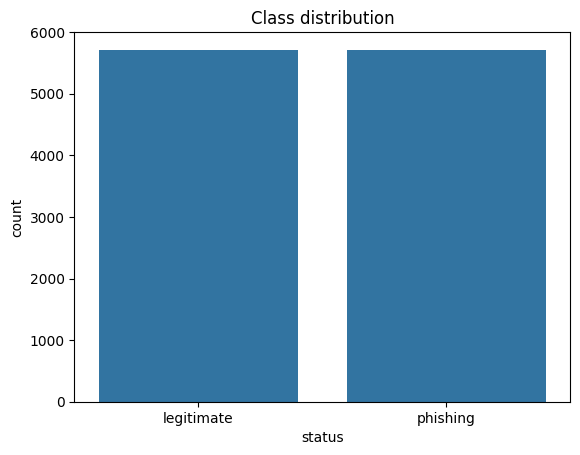

In [10]:
# Cell 4 — label check
# Replace 'status' below by your actual label name if different
label_col = 'status' # update if label column named differently
print('Label unique values:', df[label_col].unique())
print(df[label_col].value_counts(normalize=True))


# plot class distribution
sns.countplot(x=label_col, data=df)
plt.title('Class distribution')
plt.show()

In [12]:
# Cell 5 — preprocessing steps
# 1. Drop URL column (string) since we have engineered numeric features
if 'url' in df.columns:
    df = df.drop(columns=['url'])


# 2. Ensure label column present
assert label_col in df.columns, f"Label column {label_col} not found"


# 3. Separate features and target
X = df.drop(columns=[label_col])
y = df[label_col]


# 4. Convert booleans/objects to numeric where possible
# Example: if 'path_extension' or other text columns exist, drop or encode minimally for baseline
non_numeric = X.select_dtypes(include=['object']).columns.tolist()
print('Non-numeric columns (will be dropped for baseline):', non_numeric)


# drop non-numeric columns for quick baseline (we'll keep numeric columns)
X_numeric = X.select_dtypes(include=[np.number]).copy()
print('Numeric feature count:', X_numeric.shape[1])


# 5. Fill NaNs in numeric features with median
X_numeric = X_numeric.fillna(X_numeric.median())


# 6. Quick train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
X_numeric, y, test_size=0.2, random_state=42, stratify=y)


print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Non-numeric columns (will be dropped for baseline): []
Numeric feature count: 87
Train shape: (9144, 87) Test shape: (2286, 87)


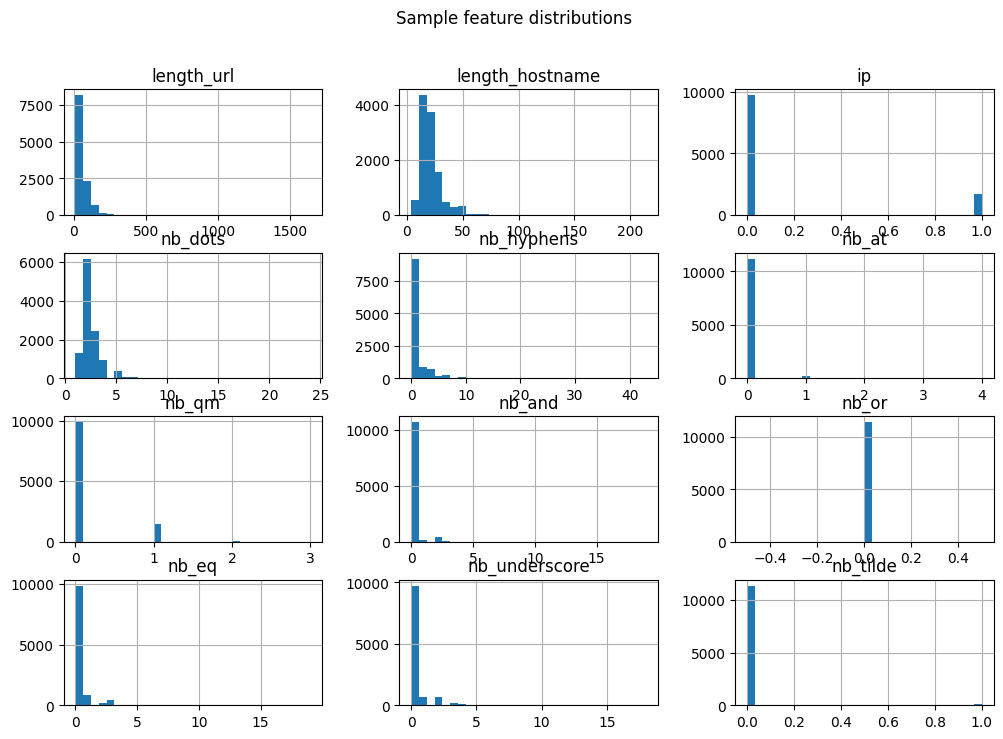

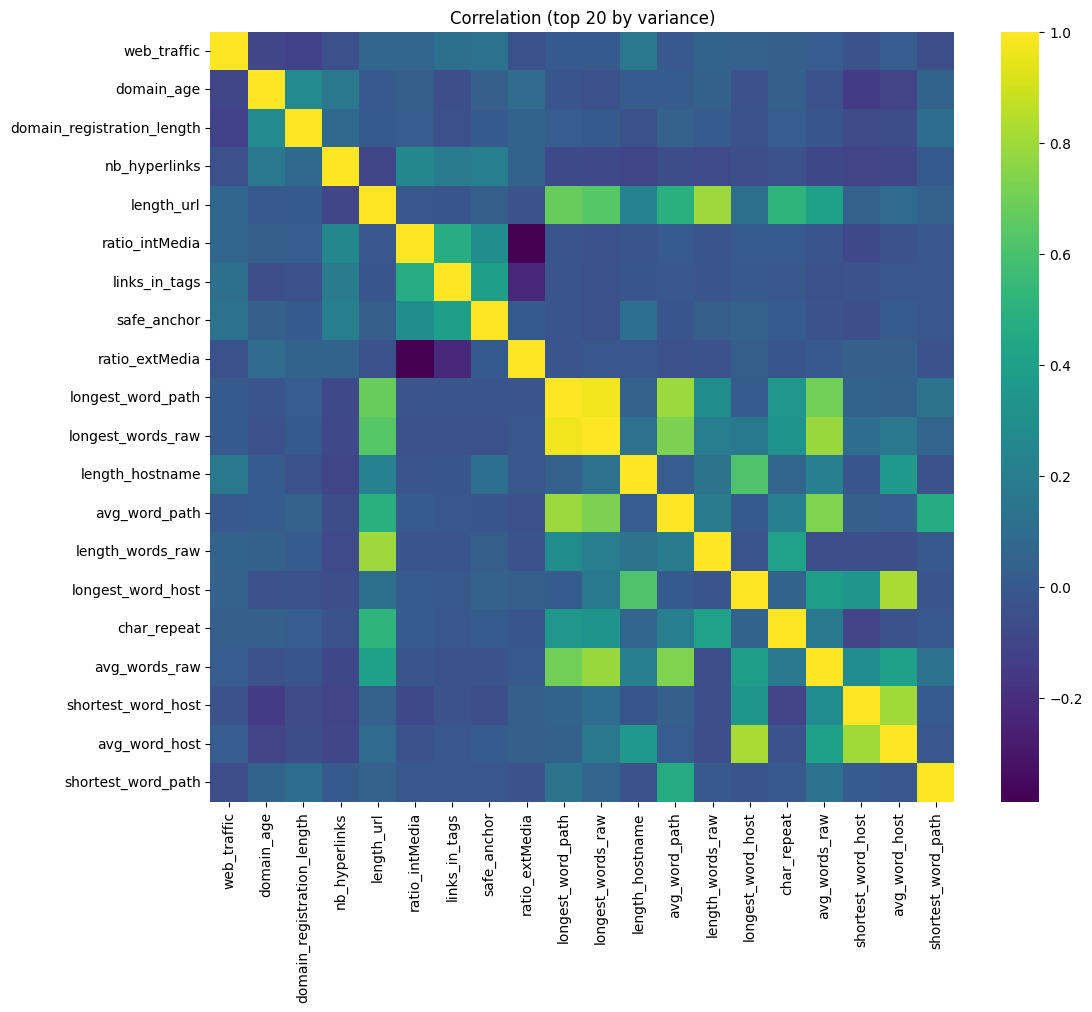

Label is not numeric; skip correlation with label


In [16]:
# Cell 6 — distributions for a sample of features
sample_cols = X_numeric.columns[:12].tolist() # change slice if you want other features
X_numeric[sample_cols].hist(figsize=(12,8), bins=30)
plt.suptitle('Sample feature distributions')
plt.show()


# Correlation heatmap (numeric features only) — pick top correlated features to avoid huge plot
corr = X_numeric.corr().abs()
# take top 20 features by variance to keep plot readable (or change as needed)
top_vars = X_numeric.var().sort_values(ascending=False).head(20).index
plt.figure(figsize=(12,10))
sns.heatmap(X_numeric[top_vars].corr(), annot=False, cmap='viridis')
plt.title('Correlation (top 20 by variance)')
plt.show()


# Print top correlations with label (if label numeric) — compute separately
if y.dtype in [int, np.int64, np.int32, float, np.float64]:
    df_corr_with_label = pd.concat([X_numeric, y], axis=1).corr()[label_col].abs().sort_values(ascending=False)
    print('Top features correlated with label:')
    print(df_corr_with_label.head(15))
else :
    print('Label is not numeric; skip correlation with label')

Classification report:
              precision    recall  f1-score   support

  legitimate       0.96      0.95      0.96      1143
    phishing       0.95      0.96      0.96      1143

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286

Confusion matrix:
[[1091   52]
 [  41 1102]]
ROC AUC: 0.9935
Top 15 feature importances:
google_index            0.180951
page_rank               0.098795
nb_hyperlinks           0.089064
web_traffic             0.073195
nb_www                  0.041778
domain_age              0.033379
phish_hints             0.030850
ratio_extHyperlinks     0.028179
ratio_intHyperlinks     0.024976
safe_anchor             0.024517
ratio_extRedirection    0.023040
longest_word_path       0.021896
length_url              0.017158
ratio_digits_url        0.016838
length_words_raw        0.016770
dtype: float64


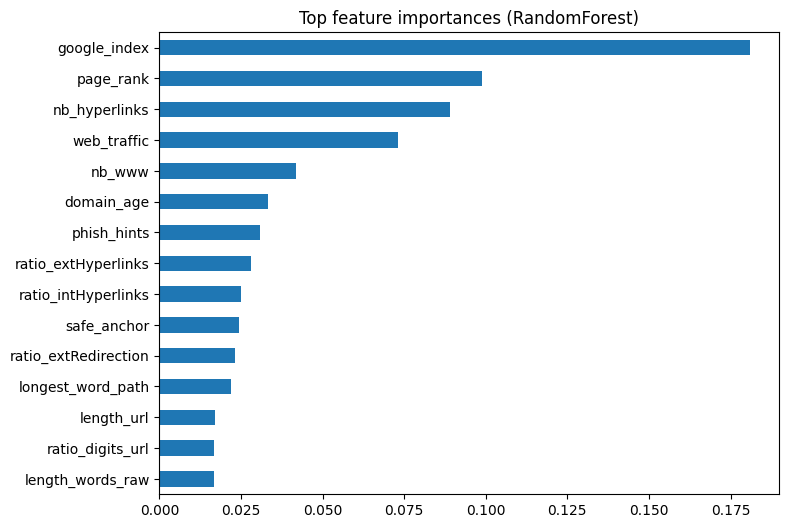

In [18]:
# Cell 7 — baseline RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)


# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1] if hasattr(rf,'predict_proba') else None


print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
if y_proba is not None:

    try:
        print('ROC AUC:', round(roc_auc_score(y_test, y_proba), 4))
    except Exception as e:
        print('ROC AUC error:', e)


# Feature importances (top 15)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
print('Top 15 feature importances:')
print(importances)


# Plot importances
plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top feature importances (RandomForest)')
plt.show()

In [25]:
# Cell 8 — save model and a sample features CSV that will be used by the app
os.makedirs('models', exist_ok=True)
joblib.dump(rf, "D:fake-website-detector/models/xgb_phish.pkl")
print("✅ Model saved to /models/xgb_phish.pkl")

# Save median-filled feature sample for later alignment when predicting single URLs
sample_features = X_numeric.median().to_frame().T
sample_features.to_csv('D:/fake-website-detector/data/features_median_sample.csv', index=False)
print('Saved sample features to data/features_median_sample.csv')

✅ Model saved to /models/xgb_phish.pkl
Saved sample features to data/features_median_sample.csv
